# Código testando as estratégias de divisão dos dados para fine-tuning

Neste código, será criado um modelo base ("model"), o qual será ajustado posteriormente com fine-tuning. O modelo base será treinado e testado utilizando o dataset Fruits 360 (https://www.kaggle.com/moltean/fruits).

O fine-tuning será feito com o dataset Supermarket Produce (ROCHA et al., 2010), utilizando diferentes estretégias de divisão dos dados (treino e teste).

As estratégias serão as seguintes:
- 1ª estratégia (1_est): 100% do dataset para teste (avaliar a capacidade de generalização do modelo base em outra base de dados sem utilizar fine-tuning);
- 2ª estratégia (2_est): 50% do dataset para treino e 50% para teste;
- 3ª estratégia (3_est): 70% do dataset para treino e 30% para teste;
- 4ª estratégia (4_est): 80% do dataset para treino e 20% para teste.

In [1]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)

from tensorflow import keras
print("versão do Keras:", keras.__version__)

# IMPORTANDO COMANDOS E FUNÇÕES #

import numpy             as np
import h5py
import matplotlib.pyplot as plt #gerar gráfico
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks           import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

import pickle

# IMPORTANDO LAYERS PARA A CNN #

from keras.models import Sequential
from keras        import layers
from keras.layers import Dropout

Versão do TensorFlow: 2.5.0
versão do Keras: 2.5.0


In [2]:
# Definindo uma semente para treinamento

semente = 13

from numpy.random import seed
seed(semente)

tf.random.set_seed(semente)

In [3]:
# MONTANDO A ESTRUTURA DA CNN #

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5)) # dropout de 50%
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(layers.Flatten()) # camada de achatamento
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(units = 11, activation = 'softmax')) # 11 unidades de saída (11 classes)

In [4]:
print("versao do h5py:", h5py.__version__)

versao do h5py: 3.1.0


In [5]:
model.summary() # resumo da estrutura, com os parâmetros ajustáveis

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [7]:
# Importando a função (criada pelo Gustavo) que faz a separação dos dados em treino e teste

from functions_extras import criar_treino_teste

In [8]:
criar_treino_teste('./dataset_fruits/', 0.25)

Criando particionamento
	 492 	+ 164 	= 656 	 -> apple1
	 492 	+ 164 	= 656 	 -> granny_smith_apple
	 466 	+ 156 	= 622 	 -> kiwi
	 492 	+ 164 	= 656 	 -> lime
	 492 	+ 164 	= 656 	 -> nectarine
	 438 	+ 146 	= 584 	 -> onion
	 492 	+ 164 	= 656 	 -> peach
	 492 	+ 164 	= 656 	 -> pear
	 421 	+ 141 	= 562 	 -> plum
	 450 	+ 150 	= 600 	 -> potato
	 474 	+ 158 	= 632 	 -> watermelon
Particionamento criado com sucesso!


In [9]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.35) # comando para reescala

# imagens de treino (65%) 

train_data = datagen.flow_from_directory('dataset_fruits/train',
                                         subset='training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (35%)

valid_data = datagen.flow_from_directory('dataset_fruits/train',
                                         subset='validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 3384 images belonging to 11 classes.
Found 1817 images belonging to 11 classes.


In [10]:
# DEFININDO O COMANDO EARLYSTOPPING #

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 13) #early stopping baseado na melhor acurácia de validação

In [11]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es],
                    verbose=True)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
53/53 [==============================] - 54s 707ms/step - loss: 2.3172 - accuracy: 0.1538 - val_loss: 1.4380 - val_accuracy: 0.5905
Epoch 2/100
53/53 [==============================] - 36s 681ms/step - loss: 1.3867 - accuracy: 0.4676 - val_loss: 0.8626 - val_accuracy: 0.7501
Epoch 3/100
53/53 [==============================] - 38s 715ms/step - loss: 0.9707 - accuracy: 0.6018 - val_loss: 0.6870 - val_accuracy: 0.8178
Epoch 4/100
53/53 [==============================] - 39s 731ms/step - loss: 0.8398 - accuracy: 0.6598 - val_loss: 0.5018 - val_accuracy: 0.8542
Epoch 5/100
53/53 [==============================] - 36s 678ms/step - loss: 0.6264 - accuracy: 0.7376 - val_loss: 0.4173 - val_accuracy: 0.8646
Epoch 6/100
53/53 [==============================] - 40s 754ms/step - loss: 0.6178 - accuracy: 0.7448 - val_loss: 0.3993 - val_accuracy: 0.8778
Epoch 7/100
53/53 [==============================] - 39s 731ms/step - loss: 0.5723 - accuracy: 0.7446 - val_loss: 0.3407 - val_accuracy:

In [12]:
model.save('model.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [13]:
model = keras.models.load_model('model.h5')
history = pickle.load(open('trainHistoryDict_model', "rb"))

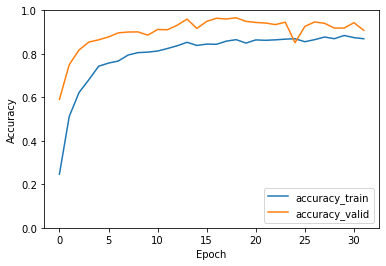

In [14]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

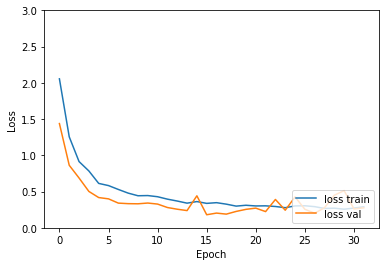

In [15]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [16]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_fruits/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 1735 images belonging to 11 classes.


In [17]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model.evaluate(test_data)

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

28/28 [==============================] - 4s 136ms/step - loss: 0.1000 - accuracy: 0.9648
acurácia nos dados de teste: 0.9648414850234985
loss dos dados de teste: 0.09997152537107468


In [18]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred)) #procurar outro comando que acesse as classes sem ordená-las automaticamente

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1735,)
Accuracy
0.9648414985590779
Balanced Accuracy
0.9642202512934219
Confusion Matrix
[[160   0   0   0   4   0   0   0   0   0   0]
 [  0 164   0   0   0   0   0   0   0   0   0]
 [  0   0 156   0   0   0   0   0   0   0   0]
 [  0   0   0 164   0   0   0   0   0   0   0]
 [  0   0   0   0 164   0   0   0   0   0   0]
 [  0   0   0   0   0 146   0   0   0   0   0]
 [  0   0   0   0   0  19 145   0   0   0   0]
 [  0   0   0   0   0   0   0 164   0   0   0]
 [  0   0   0   0   0   0   0   0 141   0   0]
 [  0   0   0   0   0  38   0   0   0 112   0]
 [  0   0   0   0   0   0   0   0   0   0 158]]
Classification Report


## Primeira estratégia: 100% teste

In [19]:
# MONTANDO A ESTRUTURA DA CNN #

model_1est = keras.models.load_model('model.h5')

In [20]:
model_1est.summary() # resumo da estrutura, com os parâmetros ajustáveis

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

In [21]:
criar_treino_teste('./dataset_smkt/', 1)

Criando particionamento
	 211 	+ 1 	= 212 	 -> apple1
	 154 	+ 1 	= 155 	 -> granny_smith_apple
	 170 	+ 1 	= 171 	 -> kiwi
	 105 	+ 1 	= 106 	 -> lime
	 246 	+ 1 	= 247 	 -> nectarine
	 74 	+ 1 	= 75 	 -> onion
	 210 	+ 1 	= 211 	 -> peach
	 158 	+ 1 	= 159 	 -> pear
	 263 	+ 1 	= 264 	 -> plum
	 200 	+ 1 	= 201 	 -> potato
	 191 	+ 1 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [22]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255) # comando para reescala

# imagens de teste (100%) 

test_data          = datagen.flow_from_directory('dataset_smkt/train', 
                                                  batch_size = 1,
                                                  target_size = (100, 100),
                                                  shuffle=False)

Found 1982 images belonging to 11 classes.


In [23]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_1est.evaluate(test_data)

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

1982/1982 [==============================] - 25s 12ms/step - loss: 15.1384 - accuracy: 0.1080
acurácia nos dados de teste: 0.10797174274921417
loss dos dados de teste: 15.138442039489746


In [24]:
Y_pred = model_1est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1982,)
Accuracy
0.10797174571140263
Balanced Accuracy
0.1561500239836446
Confusion Matrix
[[  0   0   0   0   0   8 130  72   0   0   1]
 [  0   0   0  20   0   0   6  83   0   0  45]
 [  3   0   0   3   0   1  19 103   0   0  41]
 [  0   0   0   0   0   0  28  61   0   4  12]
 [  0   0   0   0   0   0  75 171   0   0   0]
 [  3   0   1   0   0  63   3   4   0   0   0]
 [  0   0   0   0   0  10  49 151   0   0   0]
 [  2   2   0   2   0   6  28  92  11   1  14]
 [  0   0   0   0   2   1 207  22   1   0  30]
 [ 34   0   0   0   3  63   2  97   0   1   0]
 [  0  14   0  88   0   0   0  80   0   1   8]]
Classification Report


## Segunda estratégia: 50% treino 50% teste

In [25]:
# Criando modelo

model = keras.models.load_model('model.h5')

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [27]:
criar_treino_teste('./dataset_smkt/', 0.5)

Criando particionamento
	 106 	+ 106 	= 212 	 -> apple1
	 77 	+ 78 	= 155 	 -> granny_smith_apple
	 85 	+ 86 	= 171 	 -> kiwi
	 53 	+ 53 	= 106 	 -> lime
	 123 	+ 124 	= 247 	 -> nectarine
	 37 	+ 38 	= 75 	 -> onion
	 105 	+ 106 	= 211 	 -> peach
	 79 	+ 80 	= 159 	 -> pear
	 132 	+ 132 	= 264 	 -> plum
	 100 	+ 101 	= 201 	 -> potato
	 96 	+ 96 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [28]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.2) # comando para reescala + divisão em 20% para validação

# imagens de treino (80%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (20%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset = 'validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 798 images belonging to 11 classes.
Found 195 images belonging to 11 classes.


In [29]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es],
                    verbose=True)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
13/13 [==============================] - 18s 1s/step - loss: 8.5270 - accuracy: 0.1053 - val_loss: 2.1769 - val_accuracy: 0.1744
Epoch 2/100
13/13 [==============================] - 16s 1s/step - loss: 2.3769 - accuracy: 0.1679 - val_loss: 2.1395 - val_accuracy: 0.1487
Epoch 3/100
13/13 [==============================] - 16s 1s/step - loss: 2.1631 - accuracy: 0.2080 - val_loss: 2.0502 - val_accuracy: 0.1744
Epoch 4/100
13/13 [==============================] - 15s 1s/step - loss: 1.8903 - accuracy: 0.3496 - val_loss: 1.8975 - val_accuracy: 0.3487
Epoch 5/100
13/13 [==============================] - 15s 1s/step - loss: 1.6872 - accuracy: 0.4060 - val_loss: 1.7378 - val_accuracy: 0.3846
Epoch 6/100
13/13 [==============================] - 16s 1s/step - loss: 1.4857 - accuracy: 0.4737 - val_loss: 1.5150 - val_accuracy: 0.4615
Epoch 7/100
13/13 [==============================] - 15s 1s/step - loss: 1.3192 - accuracy: 0.5426 - val_loss: 1.3905 - val_accuracy: 0.4974
Epoch 8/100
1

In [30]:
model.save('model_2est.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model_2est', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [31]:
model_2est = keras.models.load_model('model_2est.h5')
history = pickle.load(open('trainHistoryDict_model_2est', "rb"))

In [32]:
model_2est.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

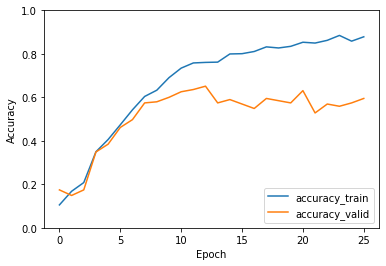

In [33]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

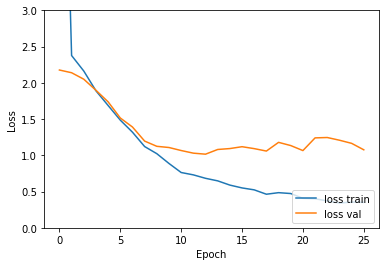

In [34]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [35]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 1000 images belonging to 11 classes.


In [36]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_2est.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

16/16 [==============================] - 11s 672ms/step - loss: 0.5773 - accuracy: 0.7930
acurácia nos dados de teste: 0.7929999828338623
loss dos dados de teste: 0.5773276686668396


In [37]:
Y_pred = model_2est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1000,)
Accuracy
0.793
Balanced Accuracy
0.7920026370152563
Confusion Matrix
[[ 62   0   1   0  32   1   5   5   0   0   0]
 [  0  73   0   0   0   0   0   1   0   0   4]
 [  0   1  51   0  22   0   1   7   0   4   0]
 [  0   6   0  39   0   0   0   1   0   0   7]
 [ 13   0   3   0 107   0   0   1   0   0   0]
 [  1   0   0   0   0  32   0   0   0   5   0]
 [  5   0   9   0   4   0  53  28   0   7   0]
 [  0   0   3   0   1   1   1  69   0   4   1]
 [  2   0   0   0   5   0   0   0 125   0   0]
 [  0   0   0   0   0   0   0   8   0  93   0]
 [  0   7   0   0   0   0   0   0   0   0  89]]
Classification Report


## Terceira estratégia: 70% treino e 30% teste

In [38]:
# Criando modelo

model = keras.models.load_model('model.h5')

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [40]:
criar_treino_teste('./dataset_smkt/', 0.3)

Criando particionamento
	 148 	+ 64 	= 212 	 -> apple1
	 108 	+ 47 	= 155 	 -> granny_smith_apple
	 119 	+ 52 	= 171 	 -> kiwi
	 74 	+ 32 	= 106 	 -> lime
	 172 	+ 75 	= 247 	 -> nectarine
	 52 	+ 23 	= 75 	 -> onion
	 147 	+ 64 	= 211 	 -> peach
	 111 	+ 48 	= 159 	 -> pear
	 184 	+ 80 	= 264 	 -> plum
	 140 	+ 61 	= 201 	 -> potato
	 134 	+ 58 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [41]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.2) # comando para reescala + divisão em 20% para validação

# imagens de treino (80%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (20%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 1117 images belonging to 11 classes.
Found 272 images belonging to 11 classes.


In [42]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es])

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
18/18 [==============================] - 24s 1s/step - loss: 6.6613 - accuracy: 0.1092 - val_loss: 2.2013 - val_accuracy: 0.1471
Epoch 2/100
18/18 [==============================] - 21s 1s/step - loss: 2.2764 - accuracy: 0.1692 - val_loss: 2.0909 - val_accuracy: 0.1912
Epoch 3/100
18/18 [==============================] - 21s 1s/step - loss: 1.9521 - accuracy: 0.2910 - val_loss: 1.8736 - val_accuracy: 0.3971
Epoch 4/100
18/18 [==============================] - 22s 1s/step - loss: 1.6456 - accuracy: 0.4118 - val_loss: 1.6070 - val_accuracy: 0.5110
Epoch 5/100
18/18 [==============================] - 21s 1s/step - loss: 1.3987 - accuracy: 0.5166 - val_loss: 1.3120 - val_accuracy: 0.5882
Epoch 6/100
18/18 [==============================] - 21s 1s/step - loss: 1.1022 - accuracy: 0.6177 - val_loss: 1.1195 - val_accuracy: 0.6507
Epoch 7/100
18/18 [==============================] - 22s 1s/step - loss: 0.9752 - accuracy: 0.6553 - val_loss: 1.0086 - val_accuracy: 0.6801
Epoch 8/100
1

In [43]:
model.save('model_3est.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model_3est', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [44]:
model_3est = keras.models.load_model('model_3est.h5')
history = pickle.load(open('trainHistoryDict_model_3est', "rb"))

In [45]:
model_3est.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

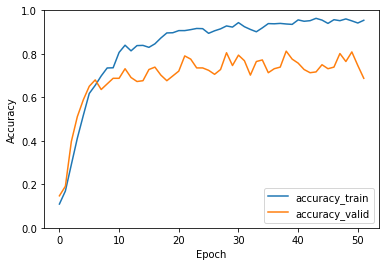

In [46]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

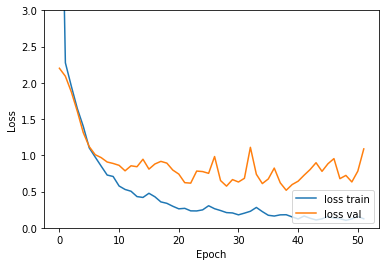

In [47]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [48]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data          = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 604 images belonging to 11 classes.


In [49]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_3est.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

10/10 [==============================] - 7s 646ms/step - loss: 0.4701 - accuracy: 0.8725
acurácia nos dados de teste: 0.8725165724754333
loss dos dados de teste: 0.4701056182384491


In [50]:
Y_pred = model_3est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(604,)
Accuracy
0.8725165562913907
Balanced Accuracy
0.8714583375753115
Confusion Matrix
[[59  0  0  0  0  0  2  3  0  0  0]
 [ 0 42  0  0  0  0  0  0  0  0  5]
 [ 0  0 33  0 11  0  1  7  0  0  0]
 [ 0  1  0 27  0  0  0  0  0  0  4]
 [ 1  0  1  0 73  0  0  0  0  0  0]
 [ 0  0  0  0  0 22  0  0  0  1  0]
 [ 5  0  7  0  0  0 34 17  0  1  0]
 [ 0  1  0  0  0  0  0 46  0  0  1]
 [ 0  0  0  0  1  0  0  0 79  0  0]
 [ 0  0  0  0  0  0  0  7  0 54  0]
 [ 0  0  0  0  0  0  0  0  0  0 58]]
Classification Report


## Quarta estratégia: 80% treino e 20% teste

In [51]:
# Criando modelo

model = keras.models.load_model('model.h5')

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [53]:
criar_treino_teste('./dataset_smkt/', 0.2)

Criando particionamento
	 169 	+ 43 	= 212 	 -> apple1
	 124 	+ 31 	= 155 	 -> granny_smith_apple
	 136 	+ 35 	= 171 	 -> kiwi
	 84 	+ 22 	= 106 	 -> lime
	 197 	+ 50 	= 247 	 -> nectarine
	 60 	+ 15 	= 75 	 -> onion
	 168 	+ 43 	= 211 	 -> peach
	 127 	+ 32 	= 159 	 -> pear
	 211 	+ 53 	= 264 	 -> plum
	 160 	+ 41 	= 201 	 -> potato
	 153 	+ 39 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [54]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.2) # comando para reescala + divisão em 20% para validação

# imagens de treino (80%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (20%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         target_size = (100, 100))

Found 1276 images belonging to 11 classes.
Found 313 images belonging to 11 classes.


In [55]:
# INÍCIO DO TREINO DO MODELO #

history = model.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    callbacks = [es])

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
20/20 [==============================] - 27s 1s/step - loss: 6.5998 - accuracy: 0.1176 - val_loss: 2.1643 - val_accuracy: 0.1949
Epoch 2/100
20/20 [==============================] - 24s 1s/step - loss: 2.1456 - accuracy: 0.2202 - val_loss: 2.0266 - val_accuracy: 0.2907
Epoch 3/100
20/20 [==============================] - 25s 1s/step - loss: 1.7494 - accuracy: 0.3848 - val_loss: 1.7702 - val_accuracy: 0.4026
Epoch 4/100
20/20 [==============================] - 24s 1s/step - loss: 1.4601 - accuracy: 0.4765 - val_loss: 1.4752 - val_accuracy: 0.5080
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 1.1901 - accuracy: 0.5846 - val_loss: 1.2665 - val_accuracy: 0.5655
Epoch 6/100
20/20 [==============================] - 25s 1s/step - loss: 0.9632 - accuracy: 0.6497 - val_loss: 1.1861 - val_accuracy: 0.5783
Epoch 7/100
20/20 [==============================] - 24s 1s/step - loss: 0.7938 - accuracy: 0.7163 - val_loss: 1.1021 - val_accuracy: 0.5783
Epoch 8/100
2

Epoch 59/100
20/20 [==============================] - 27s 1s/step - loss: 0.1248 - accuracy: 0.9545 - val_loss: 0.6856 - val_accuracy: 0.8051
Epoch 60/100
20/20 [==============================] - 27s 1s/step - loss: 0.1105 - accuracy: 0.9608 - val_loss: 0.6660 - val_accuracy: 0.8211
Epoch 61/100
20/20 [==============================] - 28s 1s/step - loss: 0.1217 - accuracy: 0.9545 - val_loss: 0.9150 - val_accuracy: 0.7348
Epoch 62/100
20/20 [==============================] - 26s 1s/step - loss: 0.1050 - accuracy: 0.9624 - val_loss: 0.6399 - val_accuracy: 0.8403
Epoch 63/100
20/20 [==============================] - 26s 1s/step - loss: 0.0763 - accuracy: 0.9710 - val_loss: 0.6086 - val_accuracy: 0.8115
Epoch 00063: early stopping


In [56]:
model.save('model_4est.h5',
          overwrite = True) 
del model

with open('trainHistoryDict_model_4est', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [57]:
model_4est = keras.models.load_model('model_4est.h5')
history = pickle.load(open('trainHistoryDict_model_4est', "rb"))

In [58]:
model_4est.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

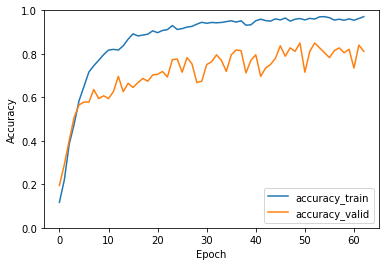

In [59]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

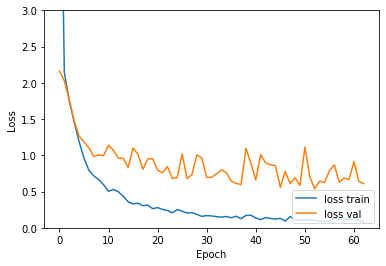

In [60]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [61]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 404 images belonging to 11 classes.


In [62]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_4est.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

7/7 [==============================] - 5s 676ms/step - loss: 0.1181 - accuracy: 0.9554
acurácia nos dados de teste: 0.9554455280303955
loss dos dados de teste: 0.11809960752725601


In [63]:
Y_pred = model_4est.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(404,)
Accuracy
0.9554455445544554
Balanced Accuracy
0.958320830626445
Confusion Matrix
[[41  0  0  0  0  0  2  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  1]
 [ 0  0 32  0  2  0  0  0  1  0  0]
 [ 0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0]
 [ 4  0  0  0  1  0 37  0  0  1  0]
 [ 0  0  0  0  0  0  1 31  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0]
 [ 0  0  0  0  0  0  0  4  0 37  0]
 [ 0  1  0  0  0  0  0  0  0  0 38]]
Classification Report


#### Referência:

ROCHA, A. et al. Automatic fruit and vegetable classification from images. Computers and Electronics in Agriculture, v. 70, n. 1, p. 96-104, 2010.